In [1]:
import os
from pydantic import Field, BaseModel
import torch
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from monai.networks.nets import UNet

from ketsu.utils import fix_global_seed
from ketsu.datasets import ConjDataset
from ketsu.main import ConjConfig, ConjModule, CustomEarlyStopping

fix_global_seed(0)
pl.seed_everything(0)
torch.set_float32_matmul_precision('medium')
device = 'cuda'

Seed set to 0


In [2]:
# from ketsu.main import CLI
# cli = CLI()
# a = CLI.TrainArgs(
#     experiment_name='base'
# )
# cli.run_train(a)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9319230914115906     │
│         test_jac          │    0.8527105450630188     │
│         test_loss         │    0.22621357440948486    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22621357440948486, 'test_acc': 0.9319230914115906, 'test_jac': 0.8527105450630188}]


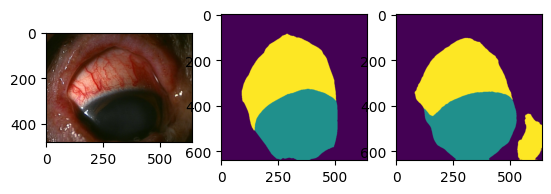

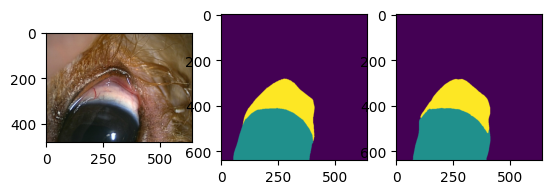

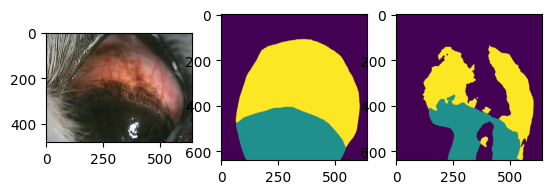

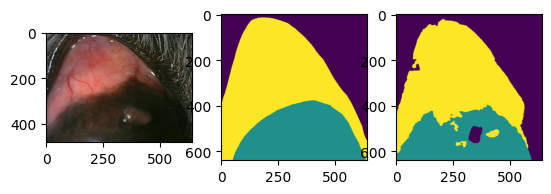

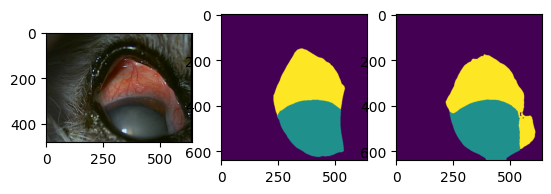

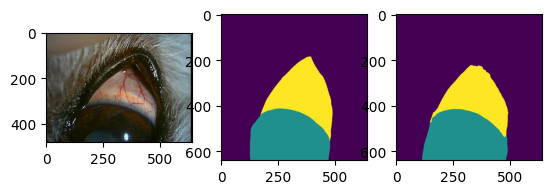

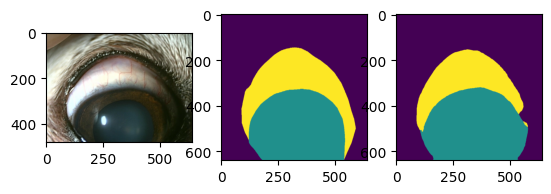

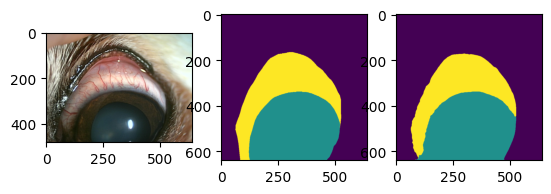

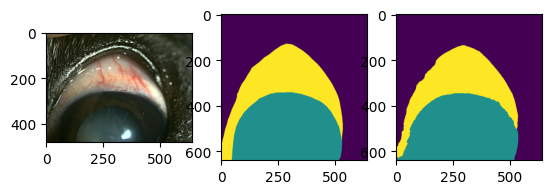

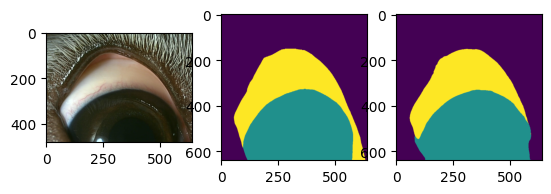

In [3]:
from torchvision import transforms

model = 'albunetn'
name = 'base'

test_ds = ConjDataset(mode='val', size=640, augmentation=False, normalization=True)
test_loader = DataLoader(test_ds, 10, num_workers=4)
trainer = pl.Trainer(
    accelerator='gpu',
    logger=False,    
    devices=1,
)

module = ConjModule.load_from_checkpoint(
    f'./checkpoints/{model}/{name}.ckpt',
)
print(trainer.test(module, test_loader))

module = module.eval().to(device)

for i in range(len(test_ds)):
    image, label = test_ds[i]
    x = image
    with torch.no_grad():
        x = x[None, ...].to(device)
        y = module(x)[0]
    y = y.detach().cpu().numpy().transpose(1, 2, 0).argmax(axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(test_ds.images[i])
    plt.subplot(1, 3, 2)
    plt.imshow(label.numpy())
    plt.subplot(1, 3, 3)
    plt.imshow(y)
    plt.show()